Purpose: The purpose of this notebook is to practice ML logistic regression models using the titanic kaggle challenge found here: https://www.kaggle.com/c/titanic/code 

Import Libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [105]:
pwd


'/Users/danielaquijano/Documents/GitHub/Python-ML'

In [106]:
#Import data from source_files folder
train = pd.read_csv('/Users/danielaquijano/Documents/GitHub/Python-ML/source_files/titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Check for missing data

In [108]:
train.isna().sum() #We get a column by column summary of the number of missing values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

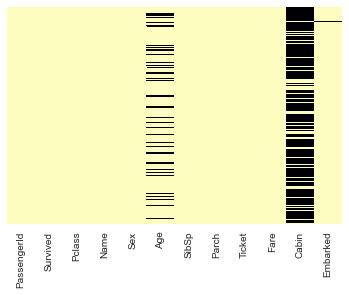

In [109]:
#Make Heat map depicting missing values by column
#Shows a lot of cabin data missing
sns.heatmap(train.isna(),yticklabels=False,cbar=False,cmap='magma_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

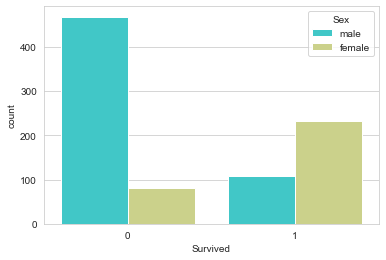

In [110]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='rainbow', hue='Sex') #More women survived compared to men

<AxesSubplot:xlabel='Survived', ylabel='count'>

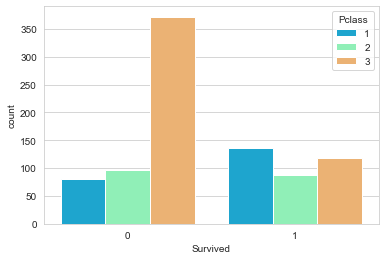

In [111]:
#Compare survivor rate based on class on the ship
#People in 3rd class (cheapest class) had the lowest survial rate
sns.countplot(x='Survived',data=train,palette='rainbow', hue='Pclass')

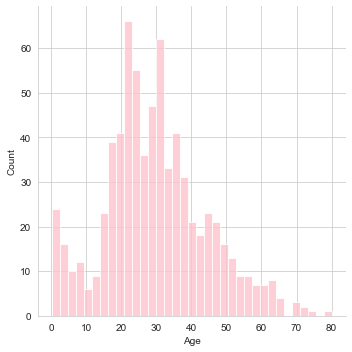

In [112]:
#Now investigate the age ditribution on the ship
#Average age between 20 and 40
sns.displot(train['Age'].dropna(),kde=False,color='pink',bins=35)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

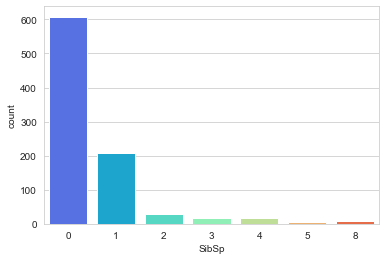

In [113]:
#Check related passengers on board (Column SibSp=siblings/spouses)
sns.countplot(x='SibSp',data=train, palette='rainbow')

In [114]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [115]:
#Check the fares paid to enter the ship
#Most tickets hover between 0 and 100
#Interactive plot with cufflinks
import cufflinks as cf
cf.go_offline()
train['Fare'].iplot(kind='hist',bins=40,color='purple')

Now, tackle missing data

In [116]:
#Use imoputation to fill in age missing values using the average age for each class
#First visualize age by class
#Higher class passengers tend to be older
box_age = train[['Pclass', 'Age']]
box_age.pivot(columns='Pclass', values='Age').iplot(kind='box')
#Here we can visualize the median valeus for each class

In [117]:
def age_replace(columns): #Pass the column for age first, then pass in the column for class
    Age = columns[0]
    Pclass = columns[1]
    
    if pd.isnull(Age): #Check if age is missing, then replace missing value with median from each class
        if Pclass == 1: 
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

<AxesSubplot:>

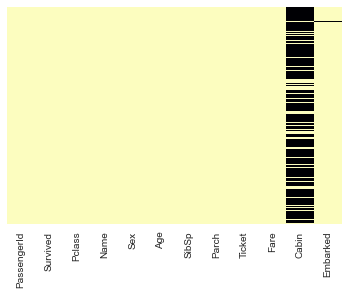

In [118]:
#Replace values in the age column by applying the function above:
train['Age'] = train[['Age','Pclass']].apply(age_replace,axis=1)
#Check heat map once again to see if values have been replaced
sns.heatmap(train.isna(),yticklabels=False,cbar=False,cmap='magma_r')


In [119]:
#Eliminate Cabin column due to large amount of missing data
train.drop('Cabin',axis=1,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [120]:
train.dropna(inplace=True) #Drop any remaining missing values

Create Dummy Variables/Indicator variables for ML input

In [121]:
#Avoid multi colinearity by making independent dataframe for male/ femaleand embark  with 'drop_first'
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [122]:
#Delete Sex, Embarked, Name and Ticket from df, concatenate new indicator variables created
#Drop additional categories that do not provide additional information to ML algorithm
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Train Logistic Regression Model (Train, Test, Split)

In [123]:
X=train.drop('Survived',axis=1) #Features
y=train['Survived'] #value that is to be predicted

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [130]:
from sklearn.linear_model import LogisticRegression
#Create instance of logistic regression model
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/danielaquijano/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [131]:
predictions = logmodel.predict(X_test)

Evaluate Model

In [137]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [138]:
print(classification_report(y_test,predictions))
#Shows the model is able to predict survival at about 80% accuracy

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       163
           1       0.82      0.71      0.76       104

    accuracy                           0.83       267
   macro avg       0.83      0.81      0.81       267
weighted avg       0.83      0.83      0.83       267



In [139]:
confusion_matrix(y_test, predictions)

array([[147,  16],
       [ 30,  74]])